# ЗАДАНИЕ

- Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
- Определить, с каких источников и в какое время суток чаще всего заходят роботы.

In [1]:
# Загрузка нужных бибриотек
import json 
import requests
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
token = 'AQAAAAAPFkraAAe5thqIDFqJPEyAuHxMMd0sPIo'
headers = {'Authorization': 'OAuth ' + token}

## Запрос к метрикам: 
- Метрики - количество визитов и доля визитов посетителей, предположительно являющихся роботами.
- Группировка - последний значимый источник, время посещения, признак isRobot

In [3]:
params = {'metrics': 'ym:s:visits,ym:s:robotPercentage',
          'dimensions':'ym:s:lastsignTrafficSource,ym:s:hour,ym:s:isRobot',
          'date1': '2020-09-01',
          'date2': '2020-09-30',
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000}
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
#print (response.status_code)
metrika_data = response.json()

## Преобразование данных в таблицу DF

Функция преобразования данных в плоский вид, избавление от вложенных словарей

In [4]:
def getMetrikaDataInListOfDicts(metrika_data):
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts

In [5]:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data) # применение функции к DF
#pprint(metrika_list_of_dicts[0:5])

In [6]:
metrika_df = pd.DataFrame(metrika_list_of_dicts) # приобразование обработанной таблицы в DF
metrika_df.columns=['source','visit_time','people_robot','visits','robot_visits%'] # переименование столбцов
display(metrika_df)

,source,visit_time,people_robot,visits,robot_visits%
0,Search engine traffic,16:00,People,189.0,0.0
1,Search engine traffic,15:00,People,177.0,0.0
2,Search engine traffic,11:00,People,169.0,0.0
3,Search engine traffic,12:00,People,169.0,0.0
4,Search engine traffic,14:00,People,167.0,0.0
...,...,...,...,...,...
177,Social network traffic,16:00,People,1.0,0.0
178,Social network traffic,16:00,Robots,1.0,100.0
179,Social network traffic,21:00,Robots,1.0,100.0
180,Recommendation system traffic,08:00,People,1.0,0.0


## 1. Рассчитаем количество ботов и их долю от всего трафика

Количество всего посещений за сентябрь 2020: 4315.0 шт
Количество ботов за сентябрь 2020: 962.0 шт
Доля ботов от всего трафика: 22.29 %


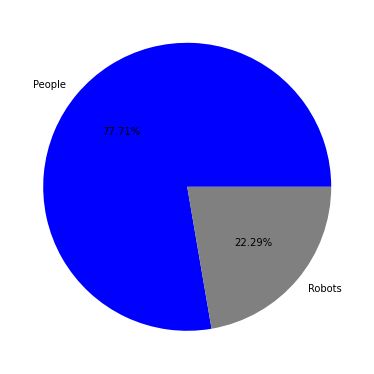

In [7]:
amount_visit_robot = metrika_df[metrika_df['people_robot']=='Robots']['visits'].sum()
amount_visit_all = metrika_df['visits'].sum()
percentage_visit_robot = amount_visit_robot/amount_visit_all*100
amount_visit = metrika_df.groupby('people_robot')['visits'].sum()

# график
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    amount_visit,
    labels=amount_visit.index,
    autopct= '%.2f%%',
    colors = ('blue', 'grey'),
    explode = [0, 0]
);
print('Количество всего посещений за сентябрь 2020:', amount_visit_all, 'шт')
print('Количество ботов за сентябрь 2020:', amount_visit_robot, 'шт')
print('Доля ботов от всего трафика:', round(percentage_visit_robot, 2),'%')

*Количество ботов составляет практически 1/4 долю всех посещений сайта - 22.29%, в количественном содержании - 962 из 4 315 посещений.*

## 2. Определим с каких источников и в какое время суток чаще всего заходят роботы.

### Определим источник посещения с максимальным количеством ботов:

Для этого создадим сводную таблицу с подсчетом визитов ботов на наш сайт сгруппированную по источникам посещений:

                        visits  visits,%
source                                  
Search engine traffic      739     76.82
Direct traffic             177     18.40
Link traffic                31      3.22
Social network traffic      11      1.14
Internal traffic             3      0.31
Cached page traffic          1      0.10


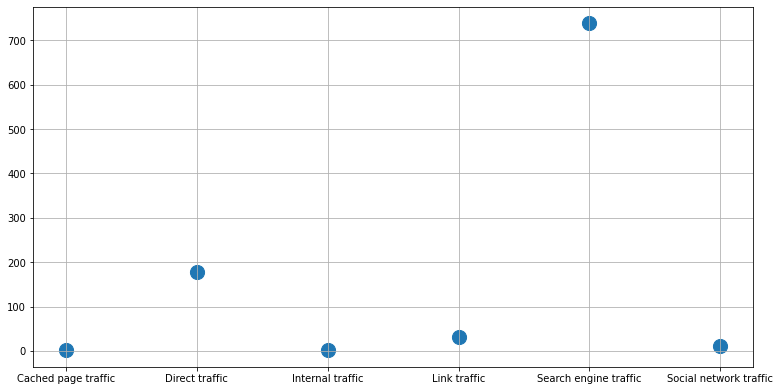

In [8]:
pt_robot_source = metrika_df.loc[metrika_df['people_robot'].isin(['Robots'])].pivot_table(values = ['visits'],
                                              index = ['source'],
                                              aggfunc = 'sum',
                                              fill_value = 0,
                                              )
pt_robot_source['visits,%'] = round(pt_robot_source['visits']/pt_robot_source['visits'].sum()*100,2)
print(pt_robot_source.sort_values('visits', ascending=False))

# график
fig = plt.figure(figsize=(10, 5), facecolor='white')
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.scatter(
    x = pt_robot_source.index,
    y = pt_robot_source.visits,
    s = 200
    );
plt.grid(which='major') # включаем основную сетку

*Как видно на графике источнику Search engine traffic принадлежит самое большое количество посещений роботами. 
Доля посещений из этого источника составляет 76,82%.*

##### Определим долю посещений роботами по источникам

In [9]:
pt_source_all = metrika_df.pivot_table(values = ['visits'],     # создаём сводную таблицуё
                                              index = ['source'],
                                              aggfunc = 'sum',
                                              fill_value = 0
                                              )
pt_source_all.columns = ['visits_all'] # переименоние столбца

pt_source_all['visits_bot'] = pt_robot_source['visits'] # добавляем столбец с данными по посещениям ботов
pt_source_all['percentage_visit_bot'] = round(pt_robot_source['visits']/pt_source_all['visits_all']*100,2) # вычисляем долю ботов
print(pt_source_all.sort_values('visits_all', ascending=False))

                               visits_all  visits_bot  percentage_visit_bot
source                                                                     
Search engine traffic                3334       739.0                 22.17
Direct traffic                        757       177.0                 23.38
Link traffic                          126        31.0                 24.60
Social network traffic                 80        11.0                 13.75
Internal traffic                       10         3.0                 30.00
Cached page traffic                     6         1.0                 16.67
Recommendation system traffic           2         NaN                   NaN


*Как видим самая большая доля ботов приходит с источника Internal traffic = 30%, но в количественном выражении их значение незначительно. Из источников Search engine traffic, Direct traffic, Link traffic приходит примерно одинаковый процент ботов - в среднем 23,38%.*

### Определим в какое время чаще всего происходят посещения ботами сайта.

            visits
visit_time        
13:00           80
12:00           75
16:00           75
14:00           74
15:00           71
11:00           70
17:00           66
09:00           51
10:00           51
19:00           48
21:00           43
18:00           41
22:00           40
20:00           36
08:00           36
23:00           30
00:00           19
01:00           13
07:00           12
06:00            8
02:00            7
04:00            6
03:00            6
05:00            4


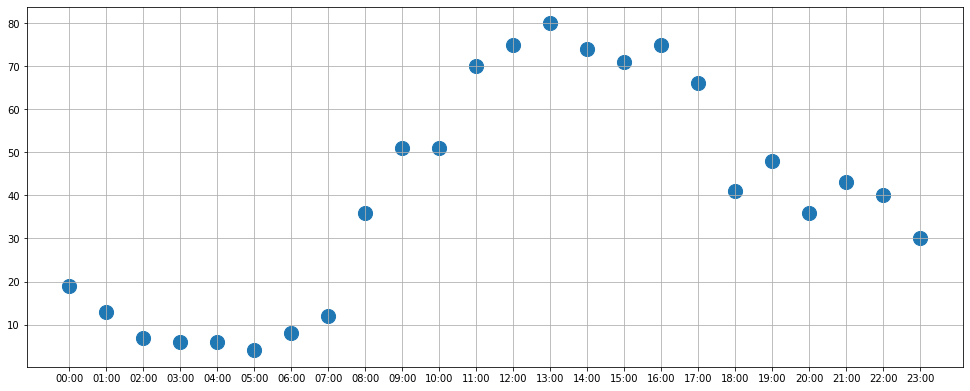

In [10]:
pt_robot_source_time = metrika_df.loc[metrika_df['people_robot'].isin(['Robots'])].pivot_table(values = ['visits'],
                                              index = ['visit_time'],
                                              aggfunc = 'sum',
                                              fill_value = 0,
                                              )
print(pt_robot_source_time.sort_values('visits', ascending=False))

# график
fig = plt.figure(figsize=(13, 5), facecolor='white')
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.scatter(
    x = pt_robot_source_time.index,
    y = pt_robot_source_time.visits,
    s = 200
    );
plt.grid(which='major') # включаем основную сетку

*Как видно на графике максимальная активность ботов с 11 до 17 часов. Пик активности приходится на 13 часов.*

### Выводы:

Количество ботов составляет практически 1/4 долю всех посещений сайта - 22.29%, в количественном содержании - 962 из 4 315 посещений. Источнику Search engine traffic принадлежит самое большое количество посещений роботами. 
Доля посещений из этого источника составляет 76,82% от общего количества посещений ботами по всем источникам. Доля ботов от общего количества посещений (люди+боты) с источника Search engine traffic составляет 22,17%.  Максимальная активность ботов происходит с 11 до 17 часов. Пик активности приходится на 13 часов.